# Forecasting non-stationary time series

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm.notebook import tqdm
from itertools import product
from typing import Union

Now we’ll **add another component to the `ARMA(p,q)` model so we can forecast
non-stationary time series.**

ARIMA(p, d, q).

## Modifying the general modeling procedure to account for non-stationary series

<img src="images/tsf_07.png">

## Forecasting a non-stationary times series

In [2]:
df = pd.read_csv('data/jj.csv')
df.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


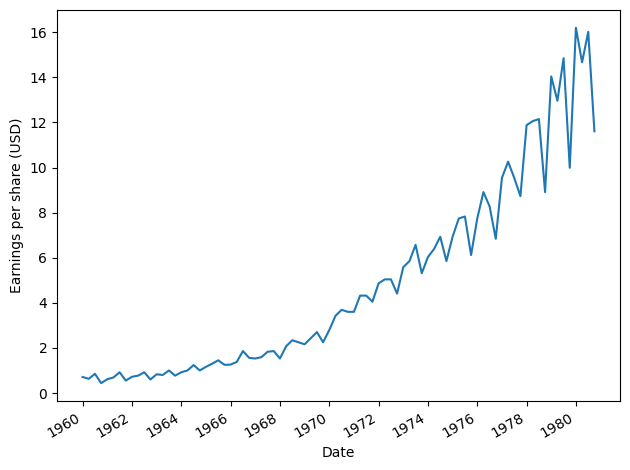

In [3]:
fig, ax = plt.subplots()

ax.plot(df.date, df['data'])
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [4]:
ad_fuller_result = adfuller(df['data'])

print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: 2.742016573457473
Critical values:
   1%: -3.524624466842421
   5%: -2.9026070739026064
   10%: -2.5886785262345677
p-value: 1.0


In [6]:
eps_diff = np.diff(df['data'], n=1)

ad_fuller_result = adfuller(eps_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -0.40740976363804543
Critical values:
   1%: -3.524624466842421
   5%: -2.9026070739026064
   10%: -2.5886785262345677
p-value: 0.9088542416911307


In [7]:
eps_diff2 = np.diff(eps_diff, n=1)

ad_fuller_result = adfuller(eps_diff2)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print("Critical values:")
for key, value in ad_fuller_result[4].items():
    print(f'   {key}: {value}')
print(f'p-value: {ad_fuller_result[1]}')

ADF Statistic: -3.585162874793184
Critical values:
   1%: -3.524624466842421
   5%: -2.9026070739026064
   10%: -2.5886785262345677
p-value: 0.006051099869603106


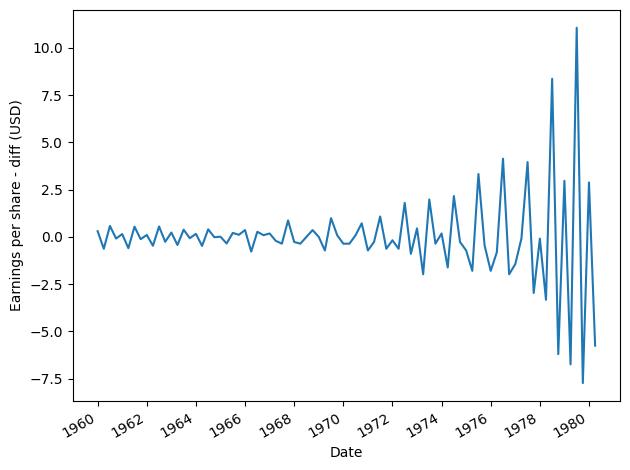

In [8]:
fig, ax = plt.subplots()

ax.plot(df['date'][2:], eps_diff2)
ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share - diff (USD)')

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])

fig.autofmt_xdate()
plt.tight_layout()

In [9]:
def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:
    
    results = []
    
    for order in tqdm(order_list):
        try: 
            model = SARIMAX(endog, order=(order[0], d, order[1]), simple_differencing=False).fit(disp=False)
        except:
            continue
            
        aic = model.aic
        results.append([order, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
ps = range(0, 4, 1)
qs = range(0, 4, 1)
d = 2

order_list = list(product(ps, qs))

In [11]:
train = df['data'][:-4]

result_df = optimize_ARIMA(train, order_list, d)
result_df


  0%|          | 0/16 [00:00<?, ?it/s]

C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

,"(p,q)",AIC
0,"(3, 3)",115.272613
1,"(3, 1)",115.624981
2,"(3, 2)",115.672010
3,"(3, 0)",154.430823
4,"(0, 3)",194.654716
5,"(0, 2)",209.274685
6,"(2, 3)",220.666872
7,"(1, 3)",228.267683
8,"(1, 2)",228.935763
9,"(2, 2)",229.974729


C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\ygreg\OneDrive\Desktop\LTFE\ICTA\03_Python_Machine_Learning\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


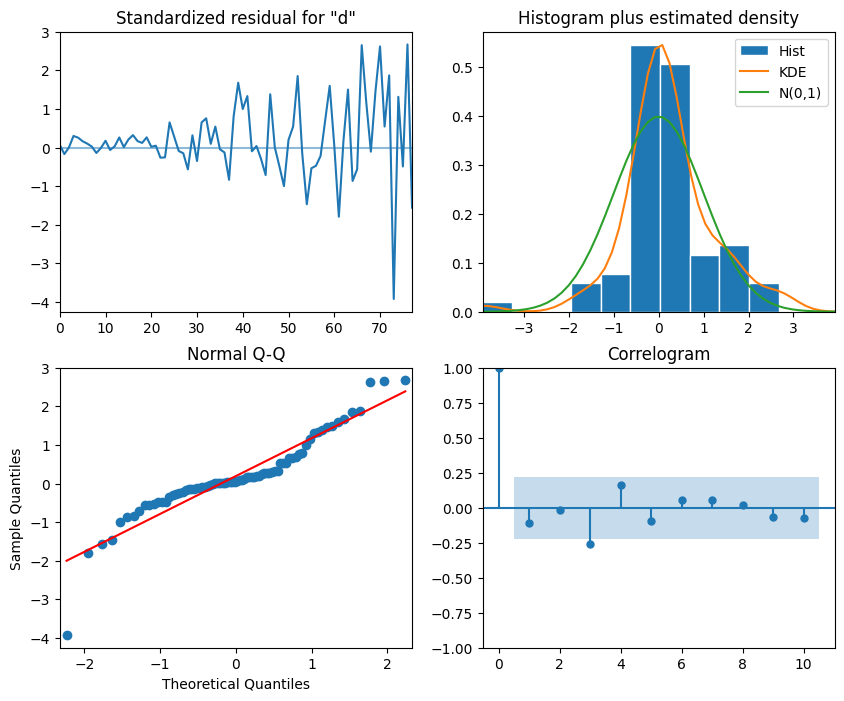

In [12]:
model = SARIMAX(train, order=(3,2,3), simple_differencing=False)
model_fit = model.fit(disp=False)
model_fit.plot_diagnostics(figsize=(10,8));
plt.show()

In [13]:
residuals = model_fit.resid

res = acorr_ljungbox(residuals, np.arange(1, 11, 1))

print(list(res["lb_pvalue"]))

[0.20149015394388803, 0.44089069753475973, 0.06311395338183862, 0.05624275546770526, 0.08045163000956573, 0.12227698704347974, 0.17195388417270677, 0.2421047548095952, 0.29832667317772454, 0.3479545491177552]


In [14]:
test = df.iloc[-4:]

test['naive_seasonal'] = df['data'].iloc[76:80].values
test

C:\Users\ygreg\AppData\Local\Temp\ipykernel_10440\3007513500.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['naive_seasonal'] = df['data'].iloc[76:80].values


,date,data,naive_seasonal
80,1980-01-01,16.20,14.04
81,1980-04-01,14.67,12.96
82,1980-07-02,16.02,14.85
83,1980-10-01,11.61,9.99


In [15]:
ARIMA_pred = model_fit.get_prediction(80, 83).predicted_mean

test['ARIMA_pred'] = ARIMA_pred
test

C:\Users\ygreg\AppData\Local\Temp\ipykernel_10440\1028357784.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['ARIMA_pred'] = ARIMA_pred


,date,data,naive_seasonal,ARIMA_pred
80,1980-01-01,16.20,14.04,15.852391
81,1980-04-01,14.67,12.96,14.382416
82,1980-07-02,16.02,14.85,16.371646
83,1980-10-01,11.61,9.99,11.680871


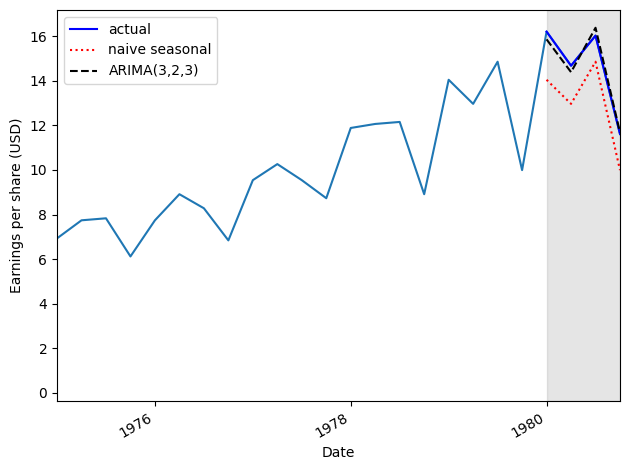

In [16]:
fig, ax = plt.subplots()

ax.plot(df['date'], df['data'])
ax.plot(test['data'], 'b-', label='actual')
ax.plot(test['naive_seasonal'], 'r:', label='naive seasonal')
ax.plot(test['ARIMA_pred'], 'k--', label='ARIMA(3,2,3)')

ax.set_xlabel('Date')
ax.set_ylabel('Earnings per share (USD)')
ax.axvspan(80, 83, color='#808080', alpha=0.2)

ax.legend(loc=2)

plt.xticks(np.arange(0, 81, 8), [1960, 1962, 1964, 1966, 1968, 1970, 1972, 1974, 1976, 1978, 1980])
ax.set_xlim(60, 83)

fig.autofmt_xdate()
plt.tight_layout()

In [17]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
mape_naive_seasonal = mape(test['data'], test['naive_seasonal'])
mape_ARIMA = mape(test['data'], test['ARIMA_pred'])

print(mape_naive_seasonal, mape_ARIMA)

11.561658552433654 1.7278902179836937


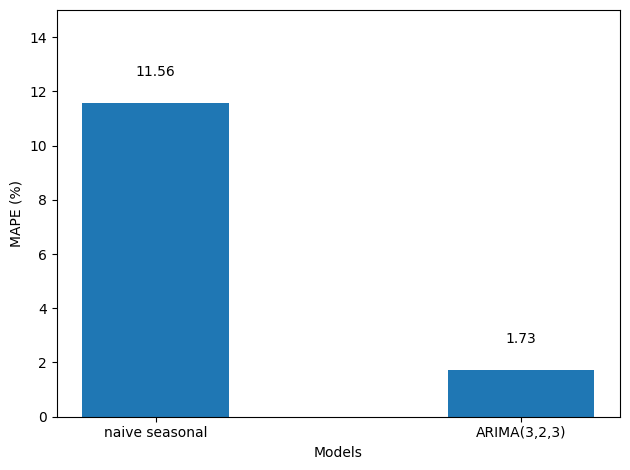

In [19]:
fig, ax = plt.subplots()

x = ['naive seasonal', 'ARIMA(3,2,3)']
y = [mape_naive_seasonal, mape_ARIMA]

ax.bar(x, y, width=0.4)
ax.set_xlabel('Models')
ax.set_ylabel('MAPE (%)')
ax.set_ylim(0, 15)

for index, value in enumerate(y):
    plt.text(x=index, y=value + 1, s=str(round(value,2)), ha='center')

plt.tight_layout()

## Summary

- The autoregressive integrated moving average model, denoted as ARIMA(p,d,q),
is the combination of the autoregressive model AR(p), the order of integration
d, and the moving average model MA(q).
- The ARIMA(p,d,q) model can be applied on non-stationary time series and
has the added advantage of returning forecasts in the same scale as the original
series.
- The order of integration d is equal to the minimum number of times a series
must be differenced to become stationary.
- An ARIMA(p,0,q) model is equivalent to an ARMA(p,q) model.